In [1]:
from __future__ import print_function

# Gridworld
This is completely over-engineered, but we will tackle this problem using different RL algorithms from future chapters.

From [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html) Example 3.5/3.8 and Berkeley [CS287: Advanced Robotics](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa12/slides/mdps-exact-methods.pdf) (see slide 30)

<img src="images/gridworld.png" width="85%" />

In [2]:
%matplotlib inline

from IPython.display import display, clear_output
from datetime import datetime, timedelta
from itertools import product
from pandas.plotting import register_matplotlib_converters

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf


pd.options.display.max_columns = None
register_matplotlib_converters()

Verify dependencies (can use image "TF2.1 Py3.6 NLP" or similar -- thanks Arman )

In [3]:
assert tf.__version__.startswith('2'), tf.__version__

In [4]:
%pip install ortools

from ortools.linear_solver import pywraplp

# need to restart notebook after installing first time
_ = pywraplp.Solver('LinearProgrammingGridworld', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

Looking in indexes: https://pypi.org/simple, https://pypi.lyft.net/pypi/
Note: you may need to restart the kernel to use updated packages.


<img src="images/gridworld2.png" width="85%" />

## The Grid
A digital [frontier](https://www.youtube.com/watch?v=4-J4duzP8Ng)...

In [5]:
# optimal strategy, gamma=0.9
expected_values = np.array([
    [22.0, 24.4, 22.0, 19.4, 17.5],
    [19.8, 22.0, 19.8, 17.8, 16.0],
    [17.8, 19.8, 17.8, 16.0, 14.4],
    [16.0, 17.8, 16.0, 14.4, 13.0],
    [14.4, 16.0, 14.4, 13.0, 11.7]
])

## Actions
[North](https://www.youtube.com/watch?v=K31sJIbv_20), [East](https://www.youtube.com/watch?v=dq3rVbGCijo), [West](https://www.youtube.com/watch?v=2LVLo61M0rY), [South](https://www.youtube.com/watch?v=zRYQJw_pYgY)

In [6]:
from enum import Enum


class Action(Enum):
    NORTH = 'N', 0, lambda x: (x[0] - 1, x[1]), (0, 1)
    EAST = 'E', 1, lambda x: (x[0], x[1] + 1), (1, 0)
    WEST = 'W', 2, lambda x: (x[0], x[1] - 1), (-1, 0)
    SOUTH = 'S', 3, lambda x: (x[0] + 1, x[1]), (0, -1)
    def __init__(self, display_name, index, transition, direction):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # numpy row-major coordinates
        self.direction = direction  # matplotlib coordinates
        
    def __str__(self):
        return self.display_name

## Agents

In [7]:
class Agent(object):
    def __init__(self, name):
        self.name = name
        
    def policy(self, state):
        """Return an Action given STATE"""
        raise NotImplementedError()


In [8]:
class GreedyAgent(Agent):
    """
    This agent has perfect information regarding the environment transition probabilities and rewards.
    
    This approach is infeasible for complex problems where the environment is unknown.
    """
    def __init__(self, state_values=None, name='Optimal', gamma=0.9):
        super().__init__(name)
        if state_values is None:
            state_values = np.random.randn(5, 5)
        self.state_values = state_values  # v(s)
        self.gamma = gamma
        
        self.environment = Gridworld()
        
    def policy(self, state):
        """Policy iteration using the exact transition/reward outcomes."""
        action = None
        max_action_value = -1000
        for a in Action:
            self.environment.set_state(state)
            s1, r = self.environment.transition(a)
            
            action_value = r + self.gamma * self.state_values[s1]
            if action_value > max_action_value:
                action = a
                max_action_value = action_value
                
        return action

In [9]:
class EpsilonGreedyAgent(GreedyAgent):
    """
    GreedyAgent with epsilon greedy exploration.
    
    This approach is infeasible for complex problems where the environment is unknown.
    """
    def __init__(self, epsilon=1e-2, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        
    def policy(self, state):
        if random.random() < self.epsilon:
            return random.choice([a for a in Action])
                
        return super().policy(state)

In [10]:
class LearnedAgent(Agent):
    """Learn the Optimal Policy beginning with a random policy and no priors."""    
    def __init__(self, name='Learned', gamma=0.9, dim=5, epsilon=0):
        super().__init__(name)
        #self.state_values = np.random.randn(5, 5)  # v(s)
        self.action_values = np.random.randn(5, 5, 4)  # q(s, a)
        self._policy = {s: random.choice([a for a in Action])
                        for s in product(range(dim), range(dim))}
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.environment = Gridworld()
        
    def policy(self, state):
        if random.random() < self.epsilon:
            return random.choice([a for a in Action])
        return self._policy[state]
    
    def policy_improvement(self):
        """Update our policy based on our latest action_values"""
        policy_stable = True
        for s, old_action in self._policy.items():
            max_action_value = -1000
            for a in Action:
                action_value = self.action_values[(s[0], s[1], a.index)]
                if action_value > max_action_value:
                    action = a
                    max_action_value = action_value
            if action != old_action:
                policy_stable = False
            self._policy[s] = action
            
        return policy_stable

## Environment

In [11]:
class Gridworld(object):
    def __init__(self, initial_state=(0, 0)):
        self.dim = 5
        self.state = initial_state
        
    def set_state(self, state):
        self.state = state

    def _transition_state(self, action):
        """Try to apply the ACTION and check whether it is valid"""
        x, y = action.transition(self.state)
        if x < 0 or x >= self.dim:
            return self.state
        elif y < 0 or y >= self.dim:
            return self.state
        return x, y
    
    def transition(self, action):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = 0
        if self.state == (0, 1):  # special state A            
            new_state = (4, 1)
            reward = 10
        elif self.state == (0, 3):  # specal state B
            new_state = (2, 3)
            reward = 5
        else:
            new_state = self._transition_state(action)
            # invalid move
            if new_state == self.state:
                reward = -1

        self.state = new_state
        return new_state, reward       

## Inspect the OptimalAgent
Given the textbook solution, our agent generally moves straight to position `(1, 4)` to collect the 10 reward.

In [12]:
def display_state_values(state_values, title=None):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    if title:
        ax.set_title(title)
    # Transform row-major numpy coords to matplotlib coords        
    transformed_values = np.rot90(state_values.T)
    im = ax.imshow(transformed_values, cmap='hot')
    fig.colorbar(im, ax=ax)
    
    agent = GreedyAgent(state_values)
    for s in product(range(5), range(5)):
        action = agent.policy(s)
        dx, dy = action.direction
        
        # Transform row-major numpy coords to matplotlib coords
        x, y = s[1], 4 - s[0]
        ax.arrow(x - 0.25 * dx, y - 0.25 * dy, 0.5 * dx, 0.5 * dy, head_width=0.05)
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)
    plt.show()

    
def display_state(state, fig=None, ax=None):
    if ax == None:        
        fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
    grid = np.zeros((5, 5))
    grid[state[0], state[1]] = 1
    ax.imshow(grid, cmap='viridis')
    display(fig)
    clear_output(wait=True)
    plt.show()

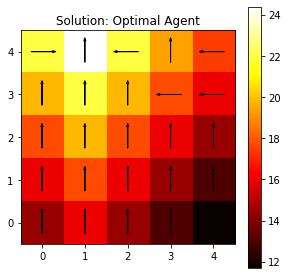

In [13]:
display_state_values(expected_values, title='Solution: Optimal Agent')

## Linear Programming Value Estimation
An exact solution, but extremely sensitive to formulation, hyperparameters, and unscaleable to anything but the simplest problems without making drastic simplifications/assumptions.

In [14]:
def solve_optimization(gamma=0.9, dim=5):
    solver = pywraplp.Solver('LinearProgrammingGridworld',
                             pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

    state_values = {s: solver.NumVar(-solver.infinity(), solver.infinity(), f'state_{s[0]}_{s[1]}')
                    for s in product(range(dim), range(dim))}
    objective = solver.Objective()
    objective.SetMinimization()
    environment = Gridworld()

    # Objective: minimize sum(v(s)) for all s
    for s0, v_s0 in state_values.items():
        objective.SetCoefficient(v_s0, 1)

        # Optimal: v(s) = max_a{r + gamma * v(s')}
        for a in Action:

            # Deterministically apply (s, a) to Gridworld to get (s', r)
            environment.set_state(s0)
            s1, r = environment.transition(a)            
            v_s1 = state_values[s1]

            # Constraint: v(s) - gamma * v(s') >= r
            constraint = solver.Constraint(r, solver.infinity())
            constraint.SetCoefficient(v_s0, 1)
            constraint.SetCoefficient(v_s1, -gamma)

    print(f'Number of variables={solver.NumVariables()}, constraints={solver.NumConstraints()}')
    solver.EnableOutput()
    status = solver.Solve() 
    if status == solver.OPTIMAL:
        values = np.zeros((5, 5))
        for (x, y), var in state_values.items():
            values[x, y] = var.solution_value()
        return values
    else:
        if status == solver.FEASIBLE:
            print('A potentially suboptimal solution was found.')
        else:
            print('The solver could not solve the problem.')    

Number of variables=25, constraints=100


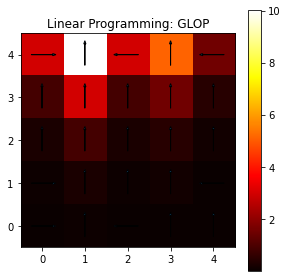

array([[ 3.00730776, 10.02435919,  3.00730776,  5.13874615,  1.54162384],
       [ 0.90219233,  3.00730776,  0.90219233,  1.54162384,  0.46248715],
       [ 0.2706577 ,  0.90219233,  0.2706577 ,  0.46248715,  0.13874615],
       [ 0.08119731,  0.2706577 ,  0.08119731,  0.13874615,  0.04162384],
       [ 0.02435919,  0.08119731,  0.02435919,  0.04162384,  0.01248715]])

In [15]:
# TODO: investigate feasability of gamma=0.9
glop_state_values = solve_optimization(gamma=0.3) 
display_state_values(glop_state_values, title='Linear Programming: GLOP')
glop_state_values

## Gradient Descent
Using gradient descent and a loss defined around the error between `v(s) - v*(s)` (big thanks to Gautam Kedia for cleaning up the loss function).

In [16]:
tf.config.experimental_run_functions_eagerly(True)


@tf.function
def get_problem(gamma, constraint_penalty, state_values=None, dim=5):
    # TODO: set better initial values
    if state_values == None:
        state_values = {s: tf.Variable(np.random.rand(), name=f'state_{s[0]}_{s[1]}', dtype=tf.float32)
                        for s in product(range(dim), range(dim))}

    errors = []
    environment = Gridworld()
    for s0, v_s0 in state_values.items():
        action_values = []
        for a in Action:       
            # Deterministically apply (s, a) to Gridworld to get (s', r)
            environment.set_state(s0)
            s1, r = environment.transition(a)            
            v_s1 = state_values[s1]

            action_value = r + gamma * v_s1
            action_values.append(action_value - v_s0)
        errors.append(tf.reduce_max(action_values))

    objective = tf.reduce_sum(tf.square(errors), name='objective')
    return objective, state_values


def plot_lp_state_values(state_values_dict, title=None):
    lp_values = np.zeros((5, 5))
    for (x, y), var in state_values_dict.items():
        lp_values[x, y] = var.numpy()
    display_state_values(lp_values, title=title)   
    return lp_values


def solve_gradients_tf(gamma=0.9, constraint_penalty=10.,
                          iterations=50000, stopping_delta=1e-4, log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1
    optimizer = tf.keras.optimizers.Adam()
    prev_loss_value = 1e9
    loss_history = []

    objective, state_values = get_problem(gamma=gamma, constraint_penalty=constraint_penalty)
    for i in range(1, iterations):
        with tf.GradientTape() as tape:    
            objective, state_values = get_problem(gamma=gamma, constraint_penalty=constraint_penalty, 
                                                  state_values=state_values)
            trainable_vars = list(state_values.values())
            loss = objective

        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))
        
        loss_value = loss.numpy()
        loss_history.append(loss_value)
        if i % log_frequency == 0:
            print(f'Iteration {i}: Loss={loss_value}')
            plot_lp_state_values(state_values, title=f'Iteration {i}')
            if abs(prev_loss_value - loss_value) < stopping_delta:
                break
            prev_loss_value = loss_value
    return state_values

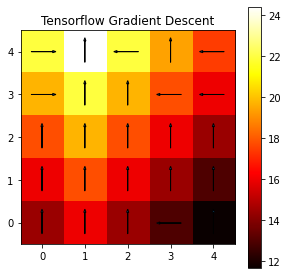

array([[21.97732735, 24.41935349, 21.97750473, 19.41955376, 17.47743034],
       [19.77977562, 21.97742844, 19.77986526, 17.80185699, 16.02178192],
       [17.80177307, 19.77975273, 17.80181694, 16.02166557, 14.41949844],
       [16.02165031, 17.80169106, 16.02163506, 14.41943741, 12.97756481],
       [14.41939545, 16.02142715, 14.4195776 , 12.97746277, 11.67983627]])

In [17]:
# Go get a coffee, this will take ~20 minutes
lp_state_values = solve_gradients_tf(gamma=0.9, stopping_delta=0.1)
plot_lp_state_values(lp_state_values, title='Tensorflow Gradient Descent')

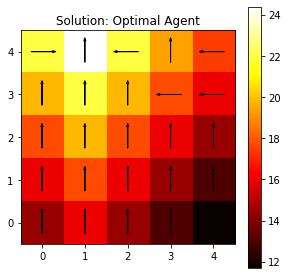

array([[22. , 24.4, 22. , 19.4, 17.5],
       [19.8, 22. , 19.8, 17.8, 16. ],
       [17.8, 19.8, 17.8, 16. , 14.4],
       [16. , 17.8, 16. , 14.4, 13. ],
       [14.4, 16. , 14.4, 13. , 11.7]])

In [18]:
# Expected (from textbook)
display_state_values(expected_values, title='Solution: Optimal Agent') 
expected_values

## Dynamic Programming: Value Iteration
Another strategy for finding the exact solution. This also requires a perfect understanding of the environment and not scaleable to complex problems. It also has weaker convergence guarantees than Linear Programming. Dynamic Programming can handle larger problems than Linear Programming, however state-space grows exponentially and we must use other methods for the largest problems.

For this toy-problem, Value Iteration is extremely efficient, solving the optimal solution in ~200ms.

In [19]:
def value_iteration(gamma=0.9, epsilon=1e-4):
    state_values = np.random.randn(5, 5)
    dim = 5
    environment = Gridworld()

    delta = 1000
    while delta > epsilon:
        delta = 0
        for s0 in product(range(dim), range(dim)):
            v_s0 = state_values[s0]

            # Policy: arg-max action-value, having perfect information about the environment
            optimal_action_value = -1000
            for a in Action:   
                # Deterministically apply (s, a) to Gridworld
                environment.set_state(s0)
                s1, r = environment.transition(a)            
                v_s1 = state_values[s1]

                action_value = r + gamma * v_s1
                optimal_action_value = max(action_value, optimal_action_value)
            state_values[s0] = optimal_action_value
            delta += abs(v_s0 - optimal_action_value)

    return state_values
            

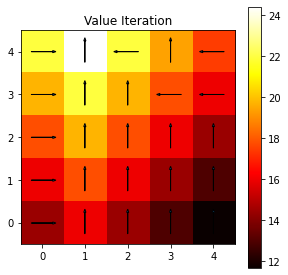

array([[21.9774764 , 24.41942227, 21.97748004, 19.41942227, 17.47748004],
       [19.77972876, 21.97748004, 19.77973204, 17.80175883, 16.02158295],
       [17.80175589, 19.77973204, 17.80175883, 16.02158295, 14.41942465],
       [16.0215803 , 17.80175883, 16.02158295, 14.41942465, 12.97748219],
       [14.41942227, 16.02158295, 14.41942465, 12.97748219, 11.67973397]])

In [20]:
vi_state_values = value_iteration()
display_state_values(vi_state_values, title='Value Iteration')
vi_state_values

## Monte Carlo
Monte Carlo is the first class of algorithm that is scaleable to complex real world problems. Unlike the previous approaches, Monte Carlo methods do not require a model of the environment, learning from both simulated episodes and actual experience. Additionally, this strategy does not require precise estimation of every state if only particular regions are relevant to our use-case.

However Monte Carlo requires a strategy for generating episodes, either for on-policy learning, off-policy learning, simulation, or back-test. None of the these algorithms generate sensible results in a reasonable amount of time without some form of exploration, such as epsilon-greedy policies. This is an extremely strong indication that a supervised learning approach would naively hammer a suboptimal policy while guaranteeing to never uncover the data necessary to get out of the local minima.

In [21]:
#  TODO: early stopping
def mc_prediction(every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    # GreedyAgent fails spectacularly here (likely supervised learning would also fail)
    agent = EpsilonGreedyAgent(name='First-Value MC Prediction')
    returns = {s: (0, 0) for s in product(range(dim), range(dim))}
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.state_values, title=f'MC Prediction: Iteration {i}')
        
        # Simulate episode
        s0 = (random.randint(0, 4), random.randint(0, 4))
        environment.set_state(s0)
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
        for _ in range(T):
            a0 = agent.policy(s0)
            s1, r1 = environment.transition(a0)
            episode.extend([a0, s1, r1]) 
            s0 = s1

        # Replay backwards from the end of the episode
        ret = 0
        j = T - 1
        episode_returns = {}
        while j > 0:
            r1 = episode[3*j + 3]
            s0 = episode[3*j - 1]
            j -= 1

            ret = r1 + gamma * ret
            episode_returns[s0] = ret
            if every_visit:
                mean_ret, c = returns[s0]
                returns[s0] = ((mean_ret * c + ret) / (c + 1), c + 1)
            
        # Update state values v(s)
        for s, ret in episode_returns.items():
            if not every_visit:
                mean_ret, c = returns[s]
                returns[s] = ((mean_ret * c + ret) / (c + 1), c + 1)
            agent.state_values[s] = returns[s][0]
    return agent

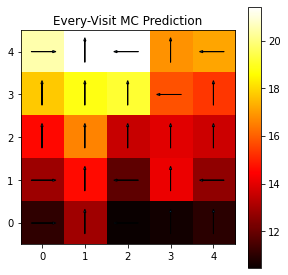

array([[20.47448467, 21.40960867, 21.39748642, 16.87823453, 17.15060415],
       [17.76865822, 18.81133812, 19.17294564, 15.81201692, 15.35823582],
       [14.60320056, 16.60668535, 13.56034364, 14.01118125, 13.66202101],
       [12.89122799, 14.65403258, 11.86426122, 14.15440767, 12.68608741],
       [11.08867266, 12.92034425, 10.47696261, 10.64692786, 11.01884875]])

In [22]:
mcp_agent = mc_prediction(every_visit=True, iterations=int(1e6), T=64)
display_state_values(mcp_agent.state_values, title='Every-Visit MC Prediction')
mcp_agent.state_values

### Every Visit
Use every available example in the episode, instead of the earliest example only for each state. In other words, use more data to estimate state-value, even if the examples near the end of the episode are not very precise estimates.

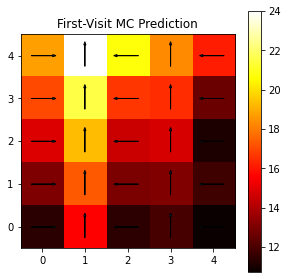

array([[18.75211569, 24.01005329, 20.76412568, 18.34102872, 16.15859583],
       [17.02322597, 21.56980765, 16.68907694, 16.49166631, 12.68134575],
       [14.90552681, 19.31303071, 14.5652678 , 14.82835762, 11.14054534],
       [13.03805846, 17.34328606, 13.00237509, 13.10052032, 11.78644226],
       [11.41536233, 15.57863577, 11.45133458, 11.9840439 , 10.74450045]])

In [23]:
mcp_agent = mc_prediction(iterations=int(1e6), T=64)
display_state_values(mcp_agent.state_values, title='First-Visit MC Prediction')
mcp_agent.state_values

### Monte Carlo Control
This is the first example in our exploration of a strategy that does not need a model of the environment. Instead, we use our Agent to interact with the environment to generate new samples. In other words, we learn through affecting users, for better or worse, even if this means giving our users a terrible experience in the short term.

In [24]:
def mc_control(every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = LearnedAgent(name='MC Control', epsilon=0.01)  # this doesn't work without some exploration
    returns = {(x, y, a): (0, 0) for x, y, a in product(range(dim), range(dim), [a for a in Action])}
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.action_values.max(axis=2), title=f'MC Control: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        s0 = (x, y)
        environment.set_state(s0)
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            episode.extend([a0, s1, r1])             
            a0 = agent.policy(s1)

        # Replay backwards from the end of the episode
        ret = 0
        j = T - 1
        episode_returns = {}
        while j > 0:
            r1 = episode[3*j + 3]
            a0 = episode[3*j + 1]
            x0, y0 = episode[3*j - 1]
            key = (x0, y0, a0)
            j -= 1

            ret = r1 + gamma * ret
            episode_returns[key] = ret
            if every_visit:
                mean_ret, c = returns[key]
                returns[key] = ((mean_ret * c + ret) / (c + 1), c + 1)

        # Update action values q(s,a)
        for (x, y, a), ret in episode_returns.items():
            key = (x, y, a)
            if not every_visit:
                mean_ret, c = returns[key]
                returns[key] = ((mean_ret * c + ret) / (c + 1), c + 1)
            agent.action_values[(x, y, a.index)] = returns[key][0]

        # Update policy
        agent.policy_improvement()
    return agent

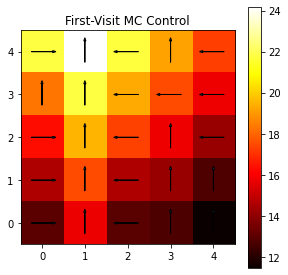

array([[21.76310244, 24.18255798, 21.74160191, 19.21809041, 17.29216626],
       [18.37533028, 21.76291097, 19.35644731, 17.57969836, 15.80375334],
       [16.37795433, 19.54407803, 17.37431728, 15.8086161 , 14.21424447],
       [14.63248892, 17.56335456, 14.6250659 , 14.21104335, 12.77971454],
       [13.02914731, 15.78233914, 13.01986135, 12.77709849, 11.4891233 ]])

In [25]:
mcc_agent = mc_control(iterations=int(1e6), T=64)
display_state_values(mcc_agent.action_values.max(axis=2), title='First-Visit MC Control')
mcc_agent.action_values.max(axis=2)

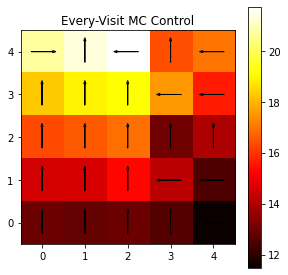

array([[20.75169663, 21.38384351, 21.7476717 , 16.43668959, 16.99919379],
       [18.32573751, 18.94891223, 19.17941004, 17.5606327 , 15.64193475],
       [16.36017431, 16.5873389 , 16.91189201, 13.07969235, 13.98904886],
       [14.57074268, 14.61895549, 15.32866503, 14.18291965, 12.5473603 ],
       [13.00030696, 12.88268697, 12.99600445, 12.6486818 , 11.48720114]])

In [26]:
mcc_agent = mc_control(every_visit=True, iterations=int(1e6), T=64)
display_state_values(mcc_agent.action_values.max(axis=2), title='Every-Visit MC Control')
mcc_agent.action_values.max(axis=2)

### Importance Sampling
Assuming our strategy for data collection obeys the *coverage* assumption (every state is visited at least once, such as by using a holdout or epsilon-greedy behavior policy), we can reasonably develop new agents without affecting users. This allows to utilize a reasonable good policy in the interim while learning better and better agents without subjecting their actions to users while they are underdeveloped.

However this strategy is extremely slow, especially if the behavior policy and target policy behave differently, in which case most episodes will not be usable by the target policy.

In [27]:
def get_policy_probs(agent, state, samples=100):
    probs = {a: 0 for a in Action}
    for _ in range(samples):
        a = agent.policy(state)
        probs[a] += 1 / samples
    return probs

# Importance Sampling
def off_policy_mc(behavior, target, gamma=0.9, 
                  dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    returns = {(x, y, a): (0, 0) for x, y, a in product(range(dim), range(dim), [a for a in Action])}
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(target.action_values.max(axis=2), title=f'MC Control: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        s0 = (x, y)
        environment.set_state(s0)
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            episode.extend([a0, s1, r1])             
            a0 = behavior.policy(s1)

        # Replay backwards from the end of the episode
        ret = 0
        j = T - 1
        w = 1
        while j > 0:
            r1 = episode[3*j + 3]
            a0 = episode[3*j + 1]
            x0, y0 = episode[3*j - 1]
            j -= 1

            key = (x0, y0, a0)
            ret = r1 + gamma * ret             
            mean_ret, c = returns[key]
            returns[key] = ((mean_ret + (w / (c + w)) * (ret - mean_ret)), c + w)
            
            # If the episode doesn't match the target policy, reject it
            target_action = target.policy((x0, y0))
            if target_action != a0:
                break
            w += get_policy_probs(behavior, (x0, y0))[a0]

        # Update policy
        for (x, y, a), ret in returns.items():
            target.action_values[(x, y, a.index)] = returns[(x, y, a)][0]
        target.policy_improvement()
    return target

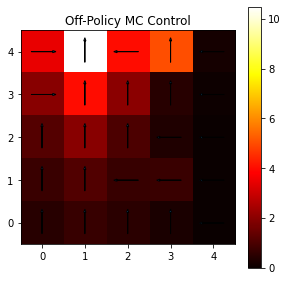

array([[ 3.48170505, 10.47917248,  4.02194575,  5.04411105,  0.18690096],
       [ 1.97226593,  4.01885467,  2.02671412,  0.48222525,  0.06681068],
       [ 1.16531412,  1.96591815,  1.05627222,  0.36358964,  0.        ],
       [ 0.76071691,  1.13036547,  0.72888747,  0.76777029,  0.        ],
       [ 0.47199288,  0.71398819,  0.49569741,  0.2827155 ,  0.        ]])

In [28]:
behavior_policy = EpsilonGreedyAgent(state_values=vi_state_values, epsilon=0.25)  # must obey assumption of coverage
target = LearnedAgent(name='Target Policy', epsilon=0)  # deterministic
off_policy_mc(behavior_policy, target, iterations=int(1e6), T=64)
display_state_values(target.action_values.max(axis=2), title='Off-Policy MC Control')
target.action_values.max(axis=2)

In [29]:
# TODO: SARSA, TD(0), Q-learning